In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## Comparison of Stan model to kaggle data analysis:

### Read in Data:

In [70]:
data = pd.read_csv("CarPrice_Assignment.csv")
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### Data Preprocessing (same as kaggle analysis):

In [71]:
# Extract brand and model from CarName
data['brand'] = data['CarName'].apply(lambda x: x.split(' ')[0])
data['model'] = data['CarName'].apply(lambda x: ' '.join(x.split(' ')[1:]))

# Define categorical and numerical columns
categorical_columns = ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
                       'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'brand', 'model']
numerical_columns = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
                     'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
                     'peakrpm', 'citympg', 'highwaympg']

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Feature engineering
data['power_to_weight_ratio'] = data['horsepower'] / data['curbweight']
for column in numerical_columns:
    data[f'{column}_squared'] = data[column] ** 2
data['log_enginesize'] = np.log(data['enginesize'] + 1)

# Feature scaling
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,curbweight_squared,enginesize_squared,boreratio_squared,stroke_squared,compressionratio_squared,horsepower_squared,peakrpm_squared,citympg_squared,highwaympg_squared,log_enginesize
0,1,3,alfa-romero giulia,1,0,1,0,2,0,-1.690772,...,6492304,16900,12.0409,7.1824,81.0,12321,25000000,441,729,4.875197
1,2,3,alfa-romero stelvio,1,0,1,0,2,0,-1.690772,...,6492304,16900,12.0409,7.1824,81.0,12321,25000000,441,729,4.875197
2,3,1,alfa-romero Quadrifoglio,1,0,1,2,2,0,-0.708596,...,7969329,23104,7.1824,12.0409,81.0,23716,25000000,361,676,5.030438
3,4,2,audi 100 ls,1,0,0,3,1,0,0.173698,...,5461569,11881,10.1761,11.5600,100.0,10404,30250000,576,900,4.700480
4,5,2,audi 100ls,1,0,0,3,0,0,0.107110,...,7974976,18496,10.1761,11.5600,64.0,13225,30250000,324,484,4.919981


<Axes: xlabel='price', ylabel='Count'>

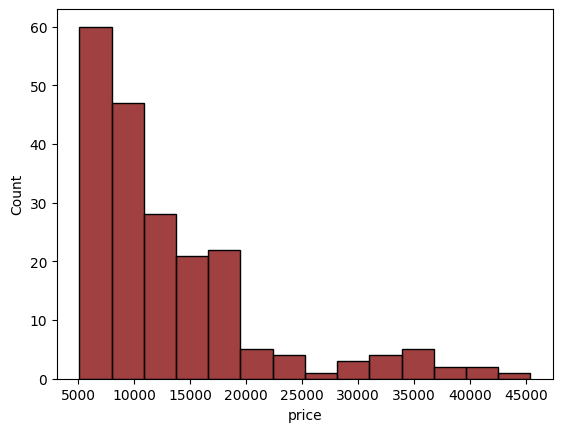

In [72]:
# Inspect the price data
sns.histplot(data.price, color='maroon')

<Axes: xlabel='price', ylabel='Count'>

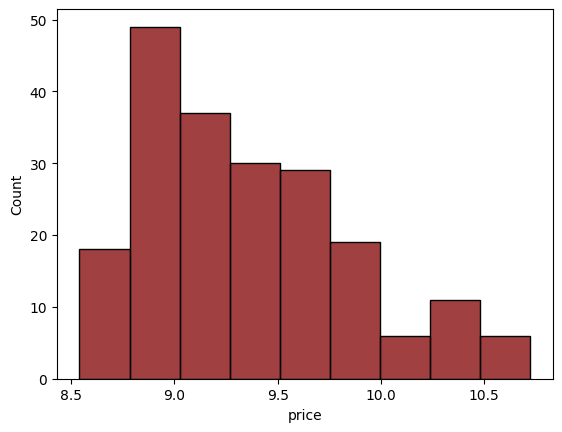

In [73]:
# Price data is not normally distribited, so do log transform
log_price = np.log(data.price)
sns.histplot(log_price, color='maroon')

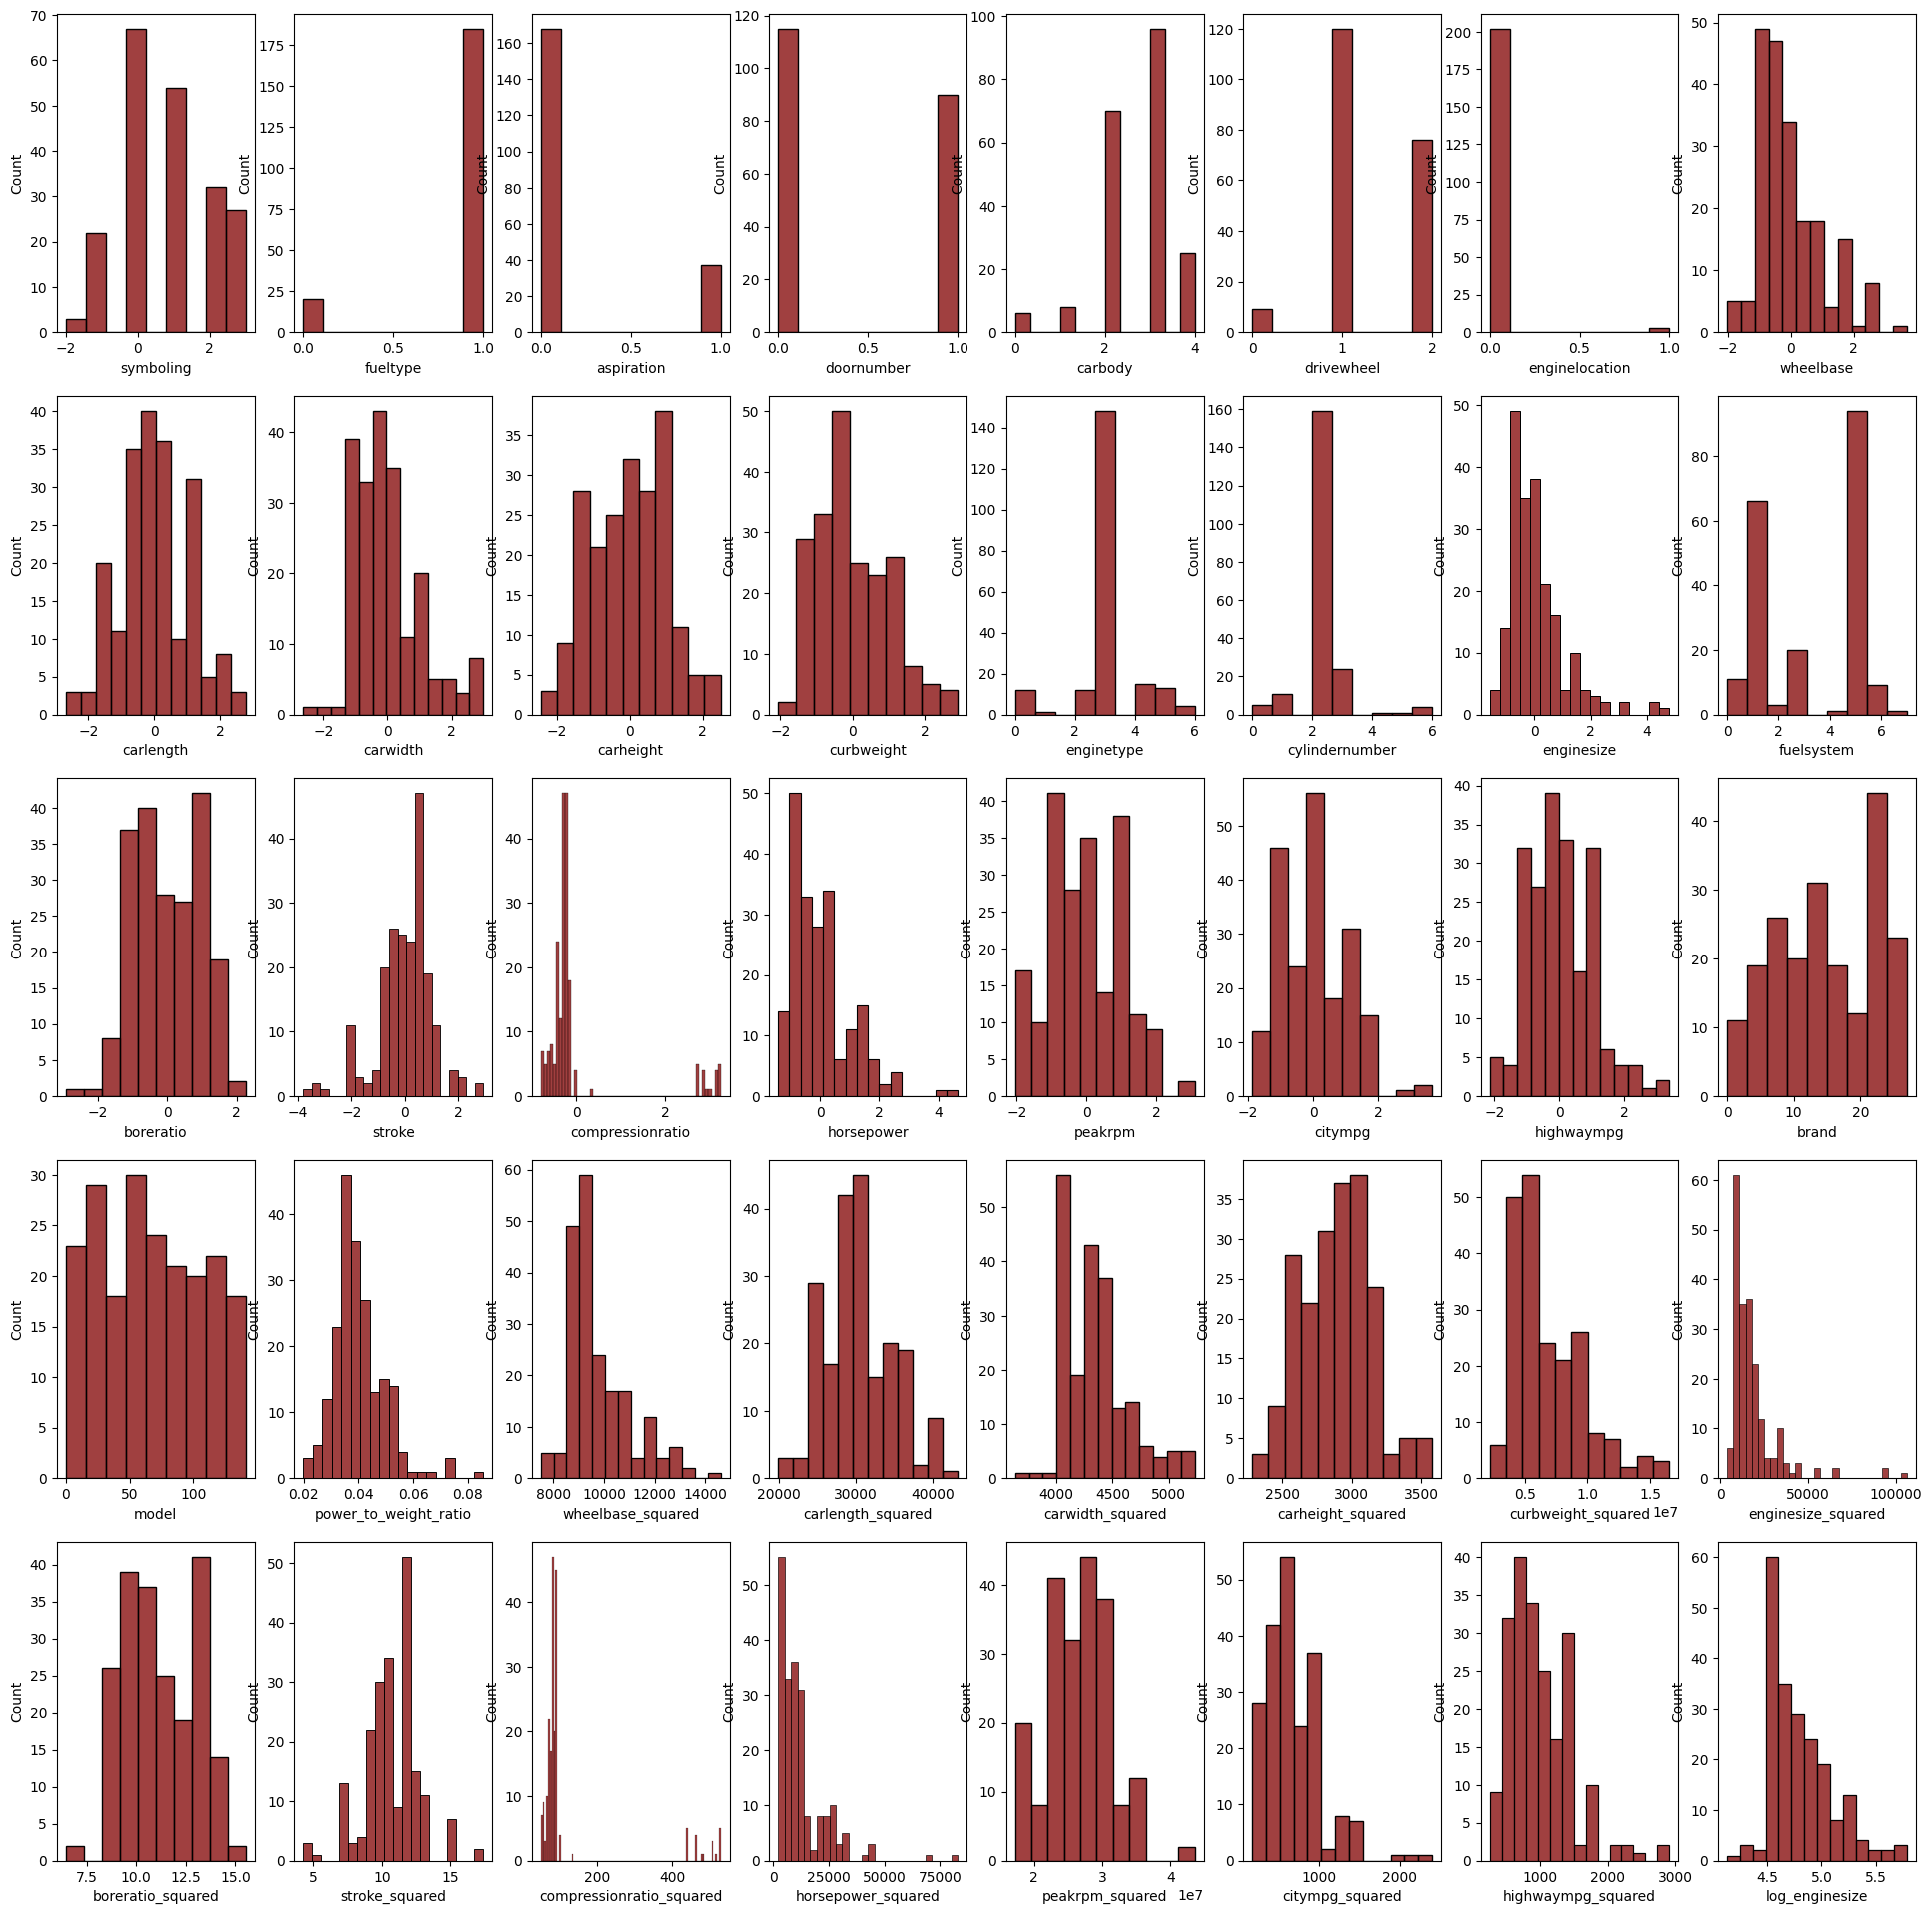

In [74]:
# Inspect histplots of all features
_, ax = plt.subplots(5, 8, figsize=(24, 24))
ax = ax.flatten()
cols = np.array(data.columns)
cols = cols[cols != 'car_ID']
cols = cols[cols != 'CarName']
cols = cols[cols != 'price']
for col, a in zip(cols, ax):
    sns.histplot(data[col], ax=a, color='maroon')

In [75]:
# Use all possible features (don't use squared or logged features that kaggle analysis uses, this makes model not converge)
use_data = data.iloc[:, :29].drop(['car_ID', 'CarName', 'price'], axis=1)
use_data.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'brand', 'model',
       'power_to_weight_ratio'],
      dtype='object')

In [76]:
# Split data into train and test set
X = np.array(use_data)
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression Stan Model:

In [77]:
program_code = """
data {
    int<lower=1> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] y;
    int<lower=1> N_test;
    matrix[N_test, K] X_test;
    real mu1;
    real mu2;
    real mu3;
    real sd1;
    real sd2;
    real sd3;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ normal(mu1, sd1);
    alpha ~ normal(mu2, sd2);
    beta ~ normal(mu2, sd3);

    // Likelihood
    y ~ normal(alpha + X * beta, sigma);
}

generated quantities {
    array[N] real gen_y;
    gen_y = normal_rng(alpha + X * beta, sigma);

    array[N_test] real pred_y;
    pred_y = normal_rng(alpha + X_test * beta, sigma);
}
"""

In [78]:
# Prepare data in Stan friendly format
data_dict = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_test': X_test.shape[0],
    'X_test': X_test,
    'mu1': 0, #mu and sd are for testing different priors
    'mu2': 9.2,
    'mu3': 9.2,
    'sd1': 10,
    'sd2': 9.2,
    'sd3': 9.2
}

# Compile model
regression_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2000 random draws from the posterior
regression_fit = regression_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%


Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2200/12000)
Sampling:  20% (2400/12000)
Sampling:  22% (2600/12000)
Sampling:  23% (2800/12000)
Sampling:  25% (3000/12000)
Sampling:  27% (3200/12000)


In [ ]:
regression_results = regression_fit.to_frame()
regression_results.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,alpha,beta.1,...,pred_y.32,pred_y.33,pred_y.34,pred_y.35,pred_y.36,pred_y.37,pred_y.38,pred_y.39,pred_y.40,pred_y.41
draws,,,,,,,,,,,,,,,,,,,,,
0,213.343584,0.997403,0.017384,8.0,255.0,0.0,-197.763492,0.155350,8.456510,-0.006201,...,8.830976,8.924882,9.617774,9.311325,10.372824,9.337560,9.129609,8.560711,9.856311,9.157916
1,215.741350,0.998397,0.017639,8.0,255.0,0.0,-189.874318,0.151899,8.562373,-0.016467,...,9.097919,9.280677,9.355810,9.273397,10.075169,9.120185,9.324406,8.908464,9.567834,8.924852
2,213.425830,0.994028,0.016293,8.0,255.0,0.0,-198.097565,0.141392,8.333691,0.017476,...,8.730234,8.849723,9.589314,8.946737,10.280334,9.550986,9.337485,8.725381,9.620213,9.032664
3,216.162067,0.960623,0.017980,8.0,255.0,0.0,-202.226079,0.152445,8.416394,-0.003855,...,8.549231,8.726868,9.793756,9.180967,10.382203,9.332607,9.546833,8.455919,9.633413,9.166801
4,213.761275,0.996395,0.017384,8.0,255.0,0.0,-200.449551,0.139857,8.165907,-0.009451,...,8.623741,9.008143,9.906972,8.980595,10.105218,9.327586,9.238673,8.587386,9.640157,9.006872


In [ ]:
regression_summary = az.summary(regression_fit)
regression_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.154,0.009,0.136,0.171,0.000,0.000,8241.0,5959.0,1.0
alpha,8.380,0.487,7.475,9.310,0.008,0.006,3619.0,4681.0,1.0
beta[0],-0.001,0.017,-0.033,0.031,0.000,0.000,7400.0,5330.0,1.0
beta[1],0.893,0.412,0.145,1.693,0.006,0.005,4151.0,4737.0,1.0
beta[2],0.052,0.055,-0.051,0.157,0.001,0.001,5899.0,6000.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_y[36],9.269,0.172,8.937,9.582,0.002,0.001,7956.0,7672.0,1.0
pred_y[37],9.333,0.172,9.004,9.648,0.002,0.001,8672.0,8014.0,1.0
pred_y[38],8.739,0.163,8.431,9.040,0.002,0.001,8103.0,8142.0,1.0
pred_y[39],9.522,0.165,9.227,9.839,0.002,0.001,7895.0,7598.0,1.0


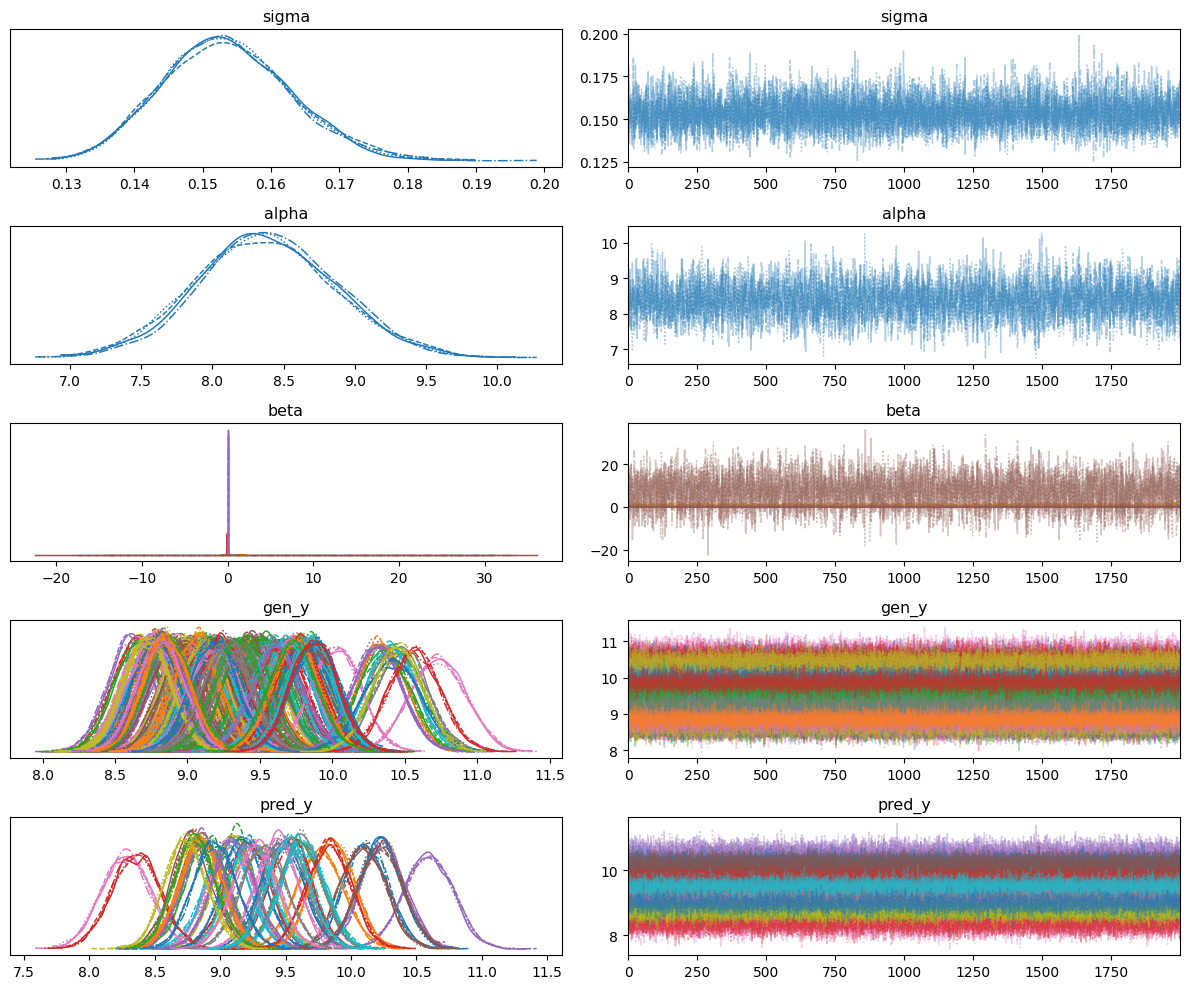

In [ ]:
_ = az.plot_trace(regression_fit)
plt.tight_layout()

<Axes: ylabel='Density'>

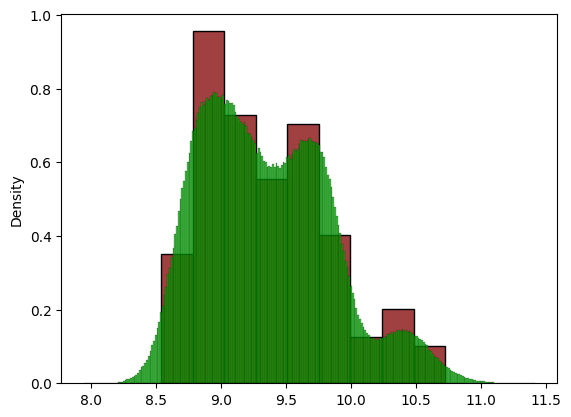

In [ ]:
# Marginal Check (Generative)
sns.histplot(y_train, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 35:199].values.flatten(), stat='density', color='#00AA00')

<Axes: ylabel='Density'>

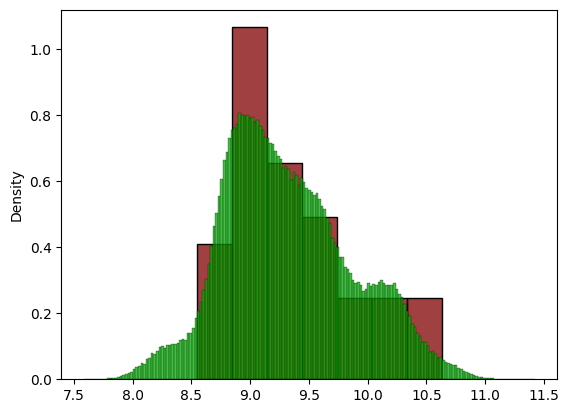

In [ ]:
# Marginal Check (Predictive)
sns.histplot(y_test, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 199:].values.flatten(), stat='density', color='#00AA00')

In [ ]:
# Generative Performance
preds = regression_fit.__getitem__('gen_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_train)**2))
r2 = r2_score(y_train, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.13932510966085154
R2-Score: 0.9216946544361354


In [ ]:
# Predictive Performance
preds = regression_fit.__getitem__('pred_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_test)**2))
r2 = r2_score(y_test, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.18066725946042042
R2-Score: 0.8796992246468843


In [ ]:
# Betas (check which have the most influence)
betas = regression_fit.__getitem__('beta')
betas_mean = betas.mean(axis=1)
betas_mean

array([-9.76396026e-04,  8.92914436e-01,  5.22010461e-02, -7.46840290e-02,
       -6.88741995e-02,  3.80314216e-02,  4.81386238e-01,  2.39338572e-02,
        2.16894895e-02,  5.48919774e-02,  3.11593599e-02,  2.07568278e-01,
        1.25585996e-02, -1.13651388e-02,  3.82691738e-02,  3.28644692e-02,
        5.69390330e-03, -2.21858637e-02,  3.30810993e-01, -2.65815307e-02,
        2.43058798e-02, -1.77547856e-01,  8.69952813e-02, -9.27371013e-03,
        4.58547243e-04,  7.28264491e+00])

#### Removing some features

In [ ]:
# Remove uninfluential features
use_data = use_data.drop(['symboling','doornumber','carbody','cylindernumber','stroke','horsepower','citympg','brand','highwaympg','boreratio','wheelbase','aspiration'], axis=1)
#use_data = use_data.drop('compressionratio', axis=1)
use_data.columns

Index(['fueltype', 'drivewheel', 'enginelocation', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'enginesize', 'fuelsystem',
       'peakrpm', 'model', 'power_to_weight_ratio'],
      dtype='object')

In [ ]:
# Split data into train and test set
X = np.array(use_data)
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression Stan Model:

In [ ]:
program_code = """
data {
    int<lower=1> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] y;
    int<lower=1> N_test;
    matrix[N_test, K] X_test;
    real mu1;
    real mu2;
    real mu3;
    real sd1;
    real sd2;
    real sd3;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ normal(mu1, sd1);
    alpha ~ normal(mu2, sd2);
    beta ~ normal(mu2, sd3);

    // Likelihood
    y ~ normal(alpha + X * beta, sigma);
}

generated quantities {
    array[N] real gen_y;
    gen_y = normal_rng(alpha + X * beta, sigma);

    array[N_test] real pred_y;
    pred_y = normal_rng(alpha + X_test * beta, sigma);
}
"""

In [ ]:
# Prepare data in Stan friendly format
data_dict = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_test': X_test.shape[0],
    'X_test': X_test,
    'mu1': 0, #mu and sd are for testing different priors
    'mu2': 9.2,
    'mu3': 9.2,
    'sd1': 10,
    'sd2': 9.2,
    'sd3': 9.2
}

# Compile model
regression_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2000 random draws from the posterior
regression_fit = regression_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   5% (600/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:  10% (1200/12000)
Sampling:  13% (1600/12000)
Sampling:  18% (2100/12000)
Sampling:  21% (2500/12000)
Sampling:  42% (5100/12000)
Sampling:  62% (7400/12000)
Sampling:  80% (9600/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 

In [ ]:
regression_results = regression_fit.to_frame()
regression_results.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,alpha,beta.1,...,pred_y.32,pred_y.33,pred_y.34,pred_y.35,pred_y.36,pred_y.37,pred_y.38,pred_y.39,pred_y.40,pred_y.41
draws,,,,,,,,,,,,,,,,,,,,,
0,196.620691,0.677304,0.047606,6.0,63.0,0.0,-188.721627,0.165015,8.820318,0.005086,...,8.737619,8.739111,9.879288,9.049489,10.085969,9.601274,9.522280,8.863022,9.590564,8.918837
1,199.140704,0.890935,0.045041,6.0,63.0,0.0,-188.231769,0.180139,8.743128,-0.093810,...,8.831322,8.518402,9.723174,8.885224,9.790872,9.495232,9.405579,9.137939,9.853919,9.152842
2,196.914591,0.991612,0.045845,7.0,127.0,0.0,-186.304335,0.170302,8.927368,-0.021897,...,8.980264,8.577566,10.069412,9.389189,10.149749,9.218479,8.996658,8.374639,9.902950,9.171823
3,192.724338,0.991623,0.040675,6.0,63.0,0.0,-187.818875,0.170864,8.682229,-0.101747,...,8.886478,8.757397,9.629766,9.191095,10.094060,8.920771,9.476883,8.480394,9.614079,9.144738
4,202.514491,0.981353,0.047606,6.0,63.0,0.0,-193.417572,0.171387,8.884999,-0.099053,...,9.026513,8.699657,9.984070,9.059669,9.754243,9.216337,9.403857,8.803536,9.400048,9.294239


In [ ]:
regression_summary = az.summary(regression_fit)
regression_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.173,0.010,0.154,0.192,0.000,0.000,7298.0,5694.0,1.0
alpha,8.877,0.116,8.651,9.088,0.002,0.001,4300.0,5216.0,1.0
beta[0],-0.091,0.060,-0.208,0.017,0.001,0.001,5582.0,5716.0,1.0
beta[1],0.072,0.034,0.011,0.137,0.000,0.000,6771.0,6338.0,1.0
beta[2],0.624,0.132,0.373,0.869,0.002,0.001,5307.0,5958.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_y[36],9.266,0.182,8.919,9.598,0.002,0.001,7682.0,7441.0,1.0
pred_y[37],9.301,0.187,8.948,9.653,0.002,0.001,8316.0,8082.0,1.0
pred_y[38],8.744,0.176,8.422,9.076,0.002,0.001,7718.0,7929.0,1.0
pred_y[39],9.634,0.177,9.297,9.958,0.002,0.001,8044.0,7564.0,1.0


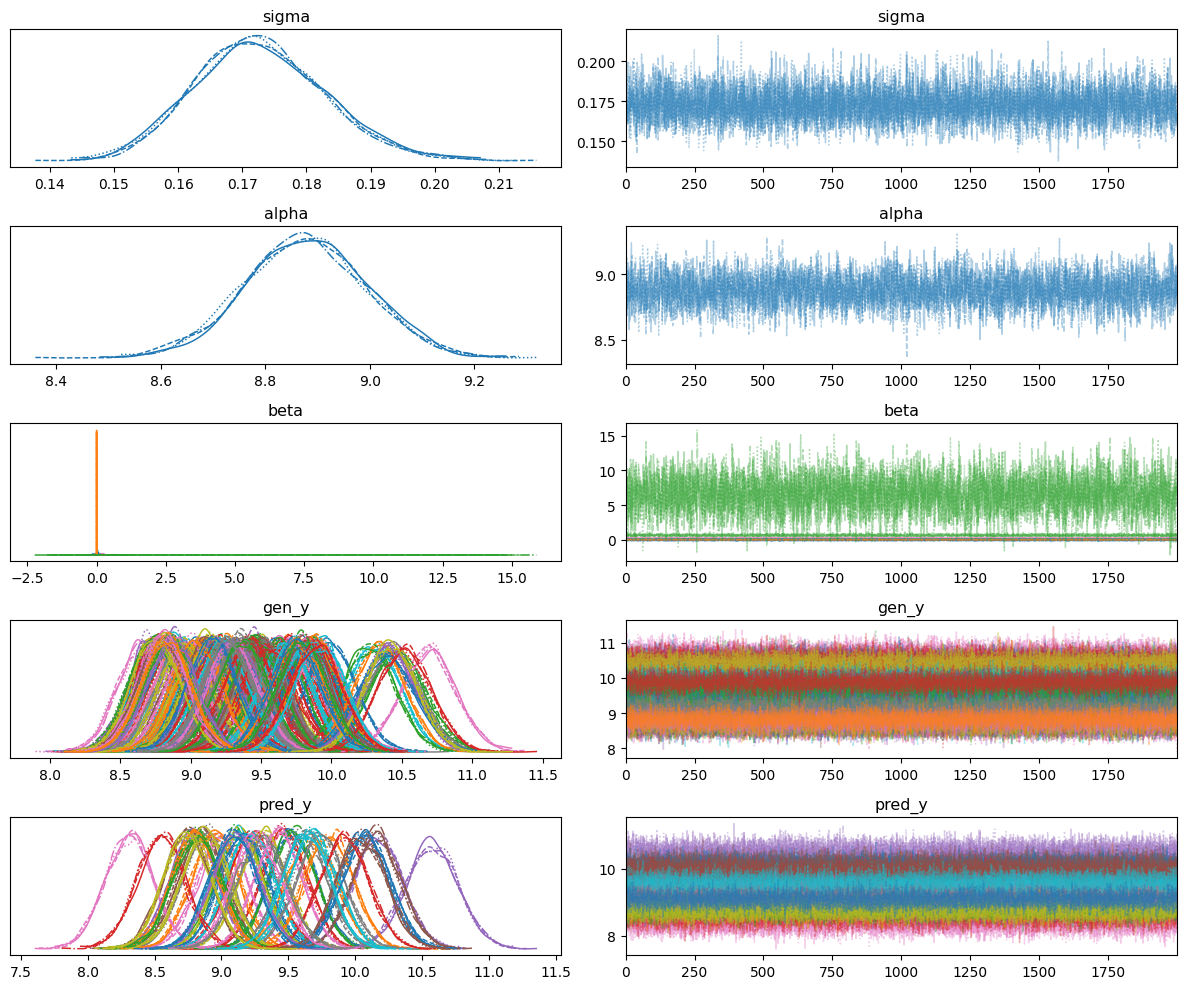

In [ ]:
_ = az.plot_trace(regression_fit)
plt.tight_layout()

<Axes: ylabel='Density'>

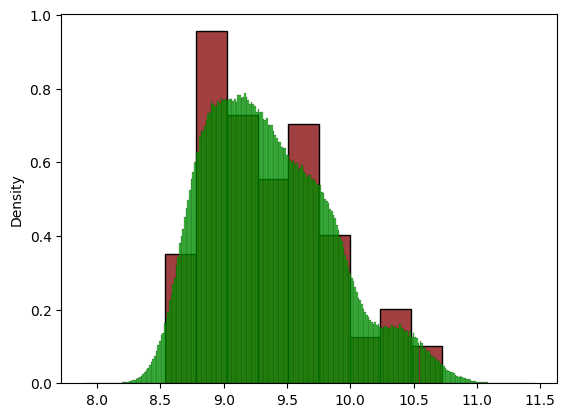

In [ ]:
# Marginal Check (Generative)
sns.histplot(y_train, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 35:199].values.flatten(), stat='density', color='#00AA00')

<Axes: ylabel='Density'>

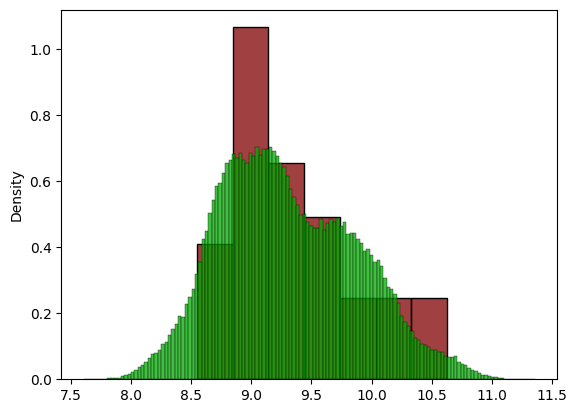

In [ ]:
# Marginal Check (Predictive)
sns.histplot(y_test, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 199:].values.flatten(), stat='density', color='#00AA00')

In [ ]:
# Generative Performance
preds = regression_fit.__getitem__('gen_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_train)**2))
r2 = r2_score(y_train, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)
'''
RMSE: 0.16380311733891875
R2-Score: 0.8917627004207458
'''

RMSE: 0.16380311733891875
R2-Score: 0.8917627004207458


In [ ]:
# Betas (check which have the most influence)
betas = regression_fit.__getitem__('beta')
betas_mean = betas.mean(axis=1)

'''
Index(['fueltype', 'drivewheel', 'enginelocation', 'carlength', 
        'carwidth', 'carheight', 'curbweight', 'enginetype', 
        'enginesize', 'fuelsystem', 'peakrpm', 'model', 
        'power_to_weight_ratio'],
      dtype='object')
'''

"\nIndex(['fueltype', 'drivewheel', 'enginelocation', 'carlength', \n        'carwidth', 'carheight', 'curbweight', 'enginetype', \n        'enginesize', 'fuelsystem', 'peakrpm', 'model', \n        'power_to_weight_ratio'],\n      dtype='object')\n"